In [111]:
import pandas as pd
import numpy as np

df = pd.read_csv('output/apt-pranoto-spei.csv')
df.set_index('Tanggal', inplace=True)
df.dropna(inplace=True)

print(len(df))
df.tail()

6316


,Tn,Tx,Tavg,RH_avg,Curah Hujan,ss,ff_x,ddd_x,ff_avg,ddd_car,Evaporasi,SPEI-1,Kategori-1,SPEI-3,Kategori-3,SPEI-6,Kategori-6
Tanggal,,,,,,,,,,,,,,,,,
2023-06-10,23.4,32.0,25.7,94.0,5.6,2.2,3.0,200.0,1.0,C,0.003978,0.188104,NO-DROUGHT,0.623395,NO-DROUGHT,0.362198,NO-DROUGHT
2023-06-11,22.4,32.0,27.0,89.0,23.2,3.3,3.0,360.0,1.0,C,0.004329,0.397850,NO-DROUGHT,0.743832,NO-DROUGHT,0.421266,NO-DROUGHT
2023-06-12,23.6,29.8,26.1,94.0,5.3,9.2,3.0,240.0,1.0,C,0.003409,0.444190,NO-DROUGHT,0.762804,NO-DROUGHT,0.425717,NO-DROUGHT
2023-06-14,23.2,31.6,26.1,92.0,3.4,2.0,5.0,230.0,1.0,C,0.003968,0.237907,NO-DROUGHT,0.764340,NO-DROUGHT,0.437342,NO-DROUGHT
2023-06-15,23.4,28.2,26.6,91.0,24.5,2.1,3.0,230.0,2.0,W,0.003034,0.452008,NO-DROUGHT,0.710351,NO-DROUGHT,0.272279,NO-DROUGHT


In [112]:
time = df.index
temperature = df['Tn']
relative_humidity = df['RH_avg']
wind_speed = df['ff_avg']

Text(0.5, 1.0, 'Wind Speed')

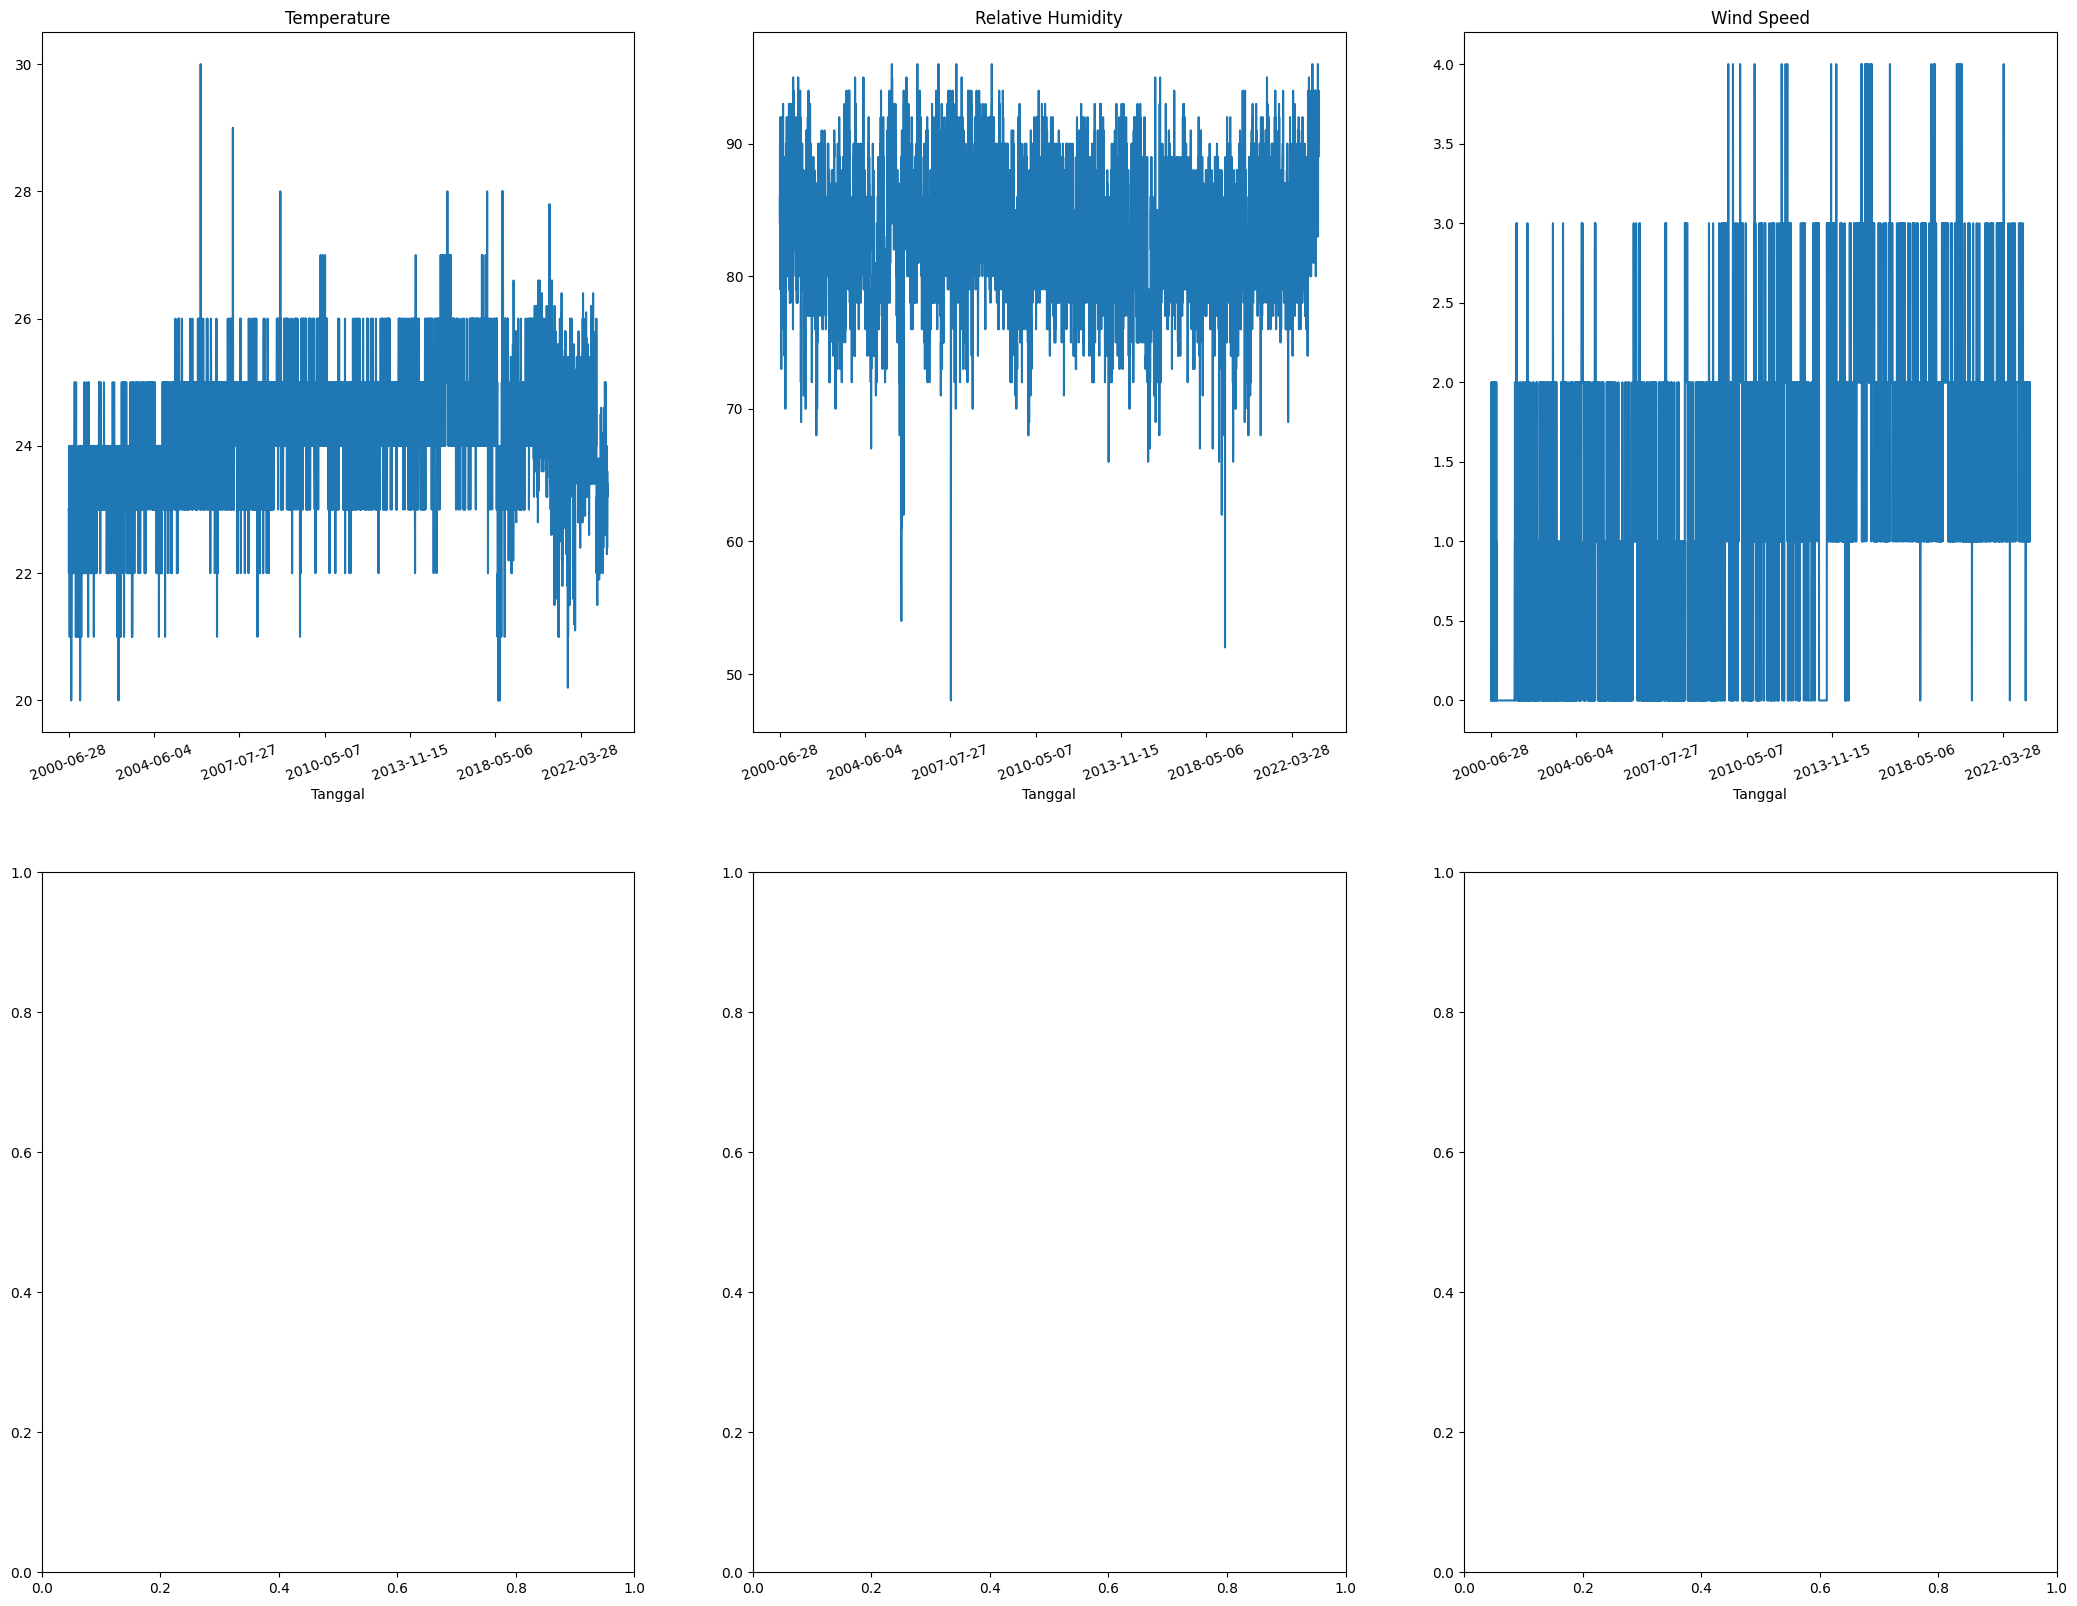

In [113]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.subplots(nrows=2, ncols=3, figsize=(26, 20))

ax = plt.subplot(2, 3, 1)
temperature.index = time
temperature.head()
temperature.plot(rot=20)
plt.title('Temperature')

ax = plt.subplot(2, 3, 2)
relative_humidity.index = time
relative_humidity.head()
relative_humidity.plot(rot=20)
plt.title('Relative Humidity')

ax = plt.subplot(2, 3, 3)
wind_speed.index = time
wind_speed.head()
wind_speed.plot(rot=20)
plt.title('Wind Speed')

In [114]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [115]:
features = pd.concat([temperature, relative_humidity, wind_speed], axis=1)
features.index = time
features

,Tn,RH_avg,ff_avg
Tanggal,,,
2000-06-28,23.0,86.0,0.0
2000-06-29,23.0,84.0,1.0
2000-06-30,23.0,90.0,0.0
2000-07-01,22.0,79.0,1.0
2000-07-02,23.0,84.0,1.0
...,...,...,...
2023-06-10,23.4,94.0,1.0
2023-06-11,22.4,89.0,1.0
2023-06-12,23.6,94.0,1.0


In [116]:
features = normalize(features.values)
features = pd.DataFrame(features)
features

,0,1,2
0,-1.165158,0.680793,-1.455286
1,-1.165158,0.277540,-0.383881
2,-1.165158,1.487299,-1.455286
3,-2.121747,-0.730593,-0.383881
4,-1.165158,0.277540,-0.383881
...,...,...,...
6311,-0.782522,2.293805,-0.383881
6312,-1.739112,1.285673,-0.383881
6313,-0.591204,2.293805,-0.383881
6314,-0.973840,1.890552,-0.383881


In [117]:
training_size = int ( 0.8 * features.shape[0])  
train_data = features.loc[0 : training_size - 1]
val_data = features.loc[training_size:]

Training Dataset

In [118]:
start = 432 + 36
end = start + training_size

x_train = train_data.values
y_train = features.iloc[start:end][[0]]

sequence_length = int(432 / 6)

In [119]:
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

Validation dataset

In [145]:
x_val_end = len(val_data) - start

label_start = training_size + start

x_val = val_data.iloc[:x_val_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

Creating an LSTM Weather Forecast Model

In [121]:
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [122]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

# grid_model = Sequential()
# grid_model.add(LSTM(100,return_sequences=True,input_shape=(n_past,154)))
# grid_model.add(LSTM(100))
# grid_model.add(Dropout(0.2))
# grid_model.add(Dense(1))
# grid_model.compile(loss = 'mse',optimizer = optimizer)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

AttributeError: Exception encountered when calling layer "lstm_14" (type LSTM).

module 'tensorflow.python.platform.build_info' has no attribute 'build_info'

Call arguments received by layer "lstm_14" (type LSTM):
  • inputs=tf.Tensor(shape=(None, 72, 3), dtype=float32)
  • mask=None
  • training=None
  • initial_state=None

In [ ]:
X = df[['Tn', 'Tx', 'Curah Hujan', 'ss', 'ff_avg', 'RH_avg']] # Predictor variables
y = df['Kategori'] # Target variable

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score

# Preprocess the data
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
split_index = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_encoded[:split_index], y_encoded[split_index:]

# Reshape the data for LSTM input (3D shape: [samples, time steps, features])
n_steps = 1
n_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], n_steps, n_features))
X_test_reshaped = X_test.reshape((X_test.shape[0], n_steps, n_features))

# Define the LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32)

# Make predictions on the testing data
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode the predicted labels
y_pred_decoded = encoder.inverse_transform(y_pred.flatten())

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", accuracy)

Epoch 1/50
162/162 [==============================] - 1s 908us/step - loss: -0.8130 - accuracy: 0.1477
Epoch 2/50
162/162 [==============================] - 0s 778us/step - loss: -10.3380 - accuracy: 0.1516
Epoch 3/50
162/162 [==============================] - 0s 748us/step - loss: -35.1577 - accuracy: 0.1516
Epoch 4/50
162/162 [==============================] - 0s 716us/step - loss: -74.2850 - accuracy: 0.1516
Epoch 5/50
162/162 [==============================] - 0s 719us/step - loss: -123.9048 - accuracy: 0.1516
Epoch 6/50
162/162 [==============================] - 0s 720us/step - loss: -182.1122 - accuracy: 0.1516
Epoch 7/50
162/162 [==============================] - 0s 723us/step - loss: -247.9528 - accuracy: 0.1516
Epoch 8/50
162/162 [==============================] - 0s 722us/step - loss: -321.0982 - accuracy: 0.1516
Epoch 9/50
162/162 [==============================] - 0s 719us/step - loss: -401.2244 - accuracy: 0.1516
Epoch 10/50
162/162 [==============================] - 0s 71

In [5]:
# %pip install tensorflow
import tensorflow as tf

print(tf)

<module 'tensorflow' (<_frozen_importlib_external.NamespaceLoader object at 0x1061bcdd0>)>


In [6]:
import pandas as pd
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('data/apt-pranoto-fix.csv')
df = df.dropna()
df.head()

,Tanggal,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,...,stasiun,Evaporasi,SPEI-30,Kategori-30,SPEI-60,Kategori-60,SPEI-90,Kategori-90,SPEI-120,Kategori-120
119,2000-04-29,23.0,34.0,27.1,82.0,39.8,3.0,3.0,180.0,0.0,...,96607,0.004644,-1.301130,MODERATE,-0.289809,NO-DROUGHT,0.161348,NO-DROUGHT,-0.322527,NO-DROUGHT
120,2000-04-30,24.0,34.0,27.6,79.0,0.0,2.1,3.0,270.0,1.0,...,96607,0.004477,-1.301132,MODERATE,-0.289809,NO-DROUGHT,0.116233,NO-DROUGHT,-0.388583,NO-DROUGHT
121,2000-05-01,23.0,28.6,25.5,94.0,57.1,0.0,13.0,270.0,1.0,...,96607,0.003195,-0.523424,MILD,-0.206821,NO-DROUGHT,0.238351,NO-DROUGHT,-0.152971,NO-DROUGHT
122,2000-05-02,24.0,30.8,26.6,90.0,3.3,0.9,3.0,180.0,0.0,...,96607,0.003611,-0.529847,MILD,-0.201010,NO-DROUGHT,0.259311,NO-DROUGHT,-0.137400,NO-DROUGHT
123,2000-05-03,23.0,32.2,27.5,82.0,0.6,3.3,5.0,270.0,1.0,...,96607,0.004285,-0.572667,MILD,-0.310848,NO-DROUGHT,0.259940,NO-DROUGHT,-0.241646,NO-DROUGHT


In [8]:
data = pd.DataFrame(list(df['Tavg']), index=df['Tanggal'], columns=['Temp'])
data

,Temp
Tanggal,
2000-04-29,27.1
2000-04-30,27.6
2000-05-01,25.5
2000-05-02,26.6
2000-05-03,27.5
...,...
2023-06-10,25.7
2023-06-11,27.0
2023-06-12,26.1


In [9]:
# We are using only data for 365 days
df = data[:365]

df.isnull().sum()
df = df.dropna(axis=0)
df.shape

(365, 1)

In [10]:
df = df.Temp.values
df[:5]

array([27.1, 27.6, 25.5, 26.6, 27.5])

In [11]:
df = df.reshape(-1,1)

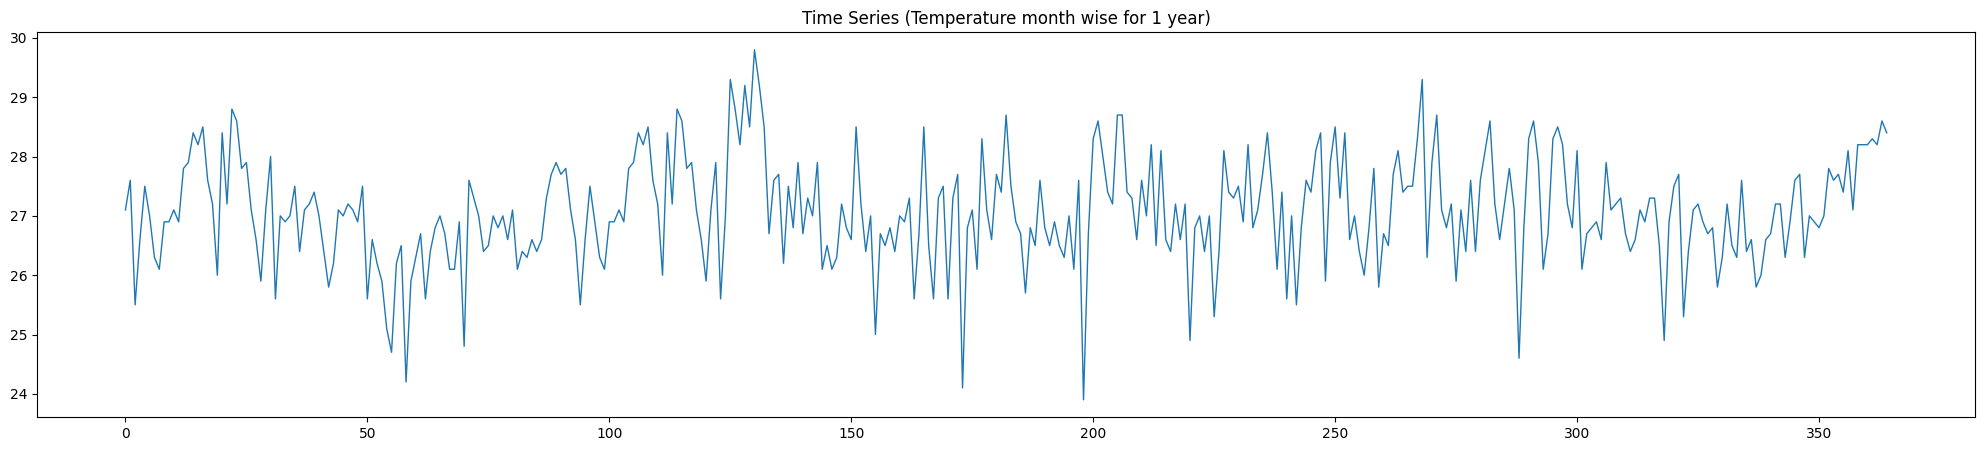

In [12]:
plt.figure(figsize=(25, 5))
plt.plot(df, linewidth=1)
plt.title("Time Series (Temperature month wise for 1 year)")
plt.show()

Scaling data

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

In [14]:
data_scaled[:5]

array([[0.54237288],
       [0.62711864],
       [0.27118644],
       [0.45762712],
       [0.61016949]])

In [15]:
data_scaled.shape

(365, 1)

In [17]:
steps= 20
inp = []
out = []
for i in range(len(data_scaled) - (steps)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps])
    
out[:10]

[array([0.76271186]),
 array([0.55932203]),
 array([0.83050847]),
 array([0.79661017]),
 array([0.66101695]),
 array([0.6779661]),
 array([0.54237288]),
 array([0.45762712]),
 array([0.33898305]),
 array([0.54237288])]

Reshape

In [18]:
import numpy as np

inp = np.asanyarray(inp)
out = np.asanyarray(out)

len(df)*0.65

237.25

In [19]:
x_train = inp[:237,:,:]
x_test = inp[237:,:,:]    
y_train = out[:237]    
y_test= out[237:]

Model Building

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (20,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (20,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
model.fit(x_train,y_train,epochs=300, verbose=1, )

In [ ]:
# model.evaluate(x_test, y_test)

Predictions and Model evaluation

Predictions on training set

In [ ]:
print("Predicted Value",model.predict(x_train)[4][0])
print("Expected value",y_train[4][0])

Predictions on testing set

In [ ]:
predictions=model.predict(x_test)

In [ ]:
print("Predicted Value",predictions[2][0])
print("Expected Value",y_test[2][0])

In [ ]:
predictions.shape

In [ ]:
y_test.shape

In [ ]:
pred_df=pd.DataFrame(predictions)

In [ ]:
pred_df['TrueValues']=y_test

In [ ]:
pred_df_new = pred_df.rename(columns={ 0: 'Predictions'})
pred_df_new

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data= pred_df_new)
plt.title("Predictions VS True Values on Testing Set")

Weather Predictions for next 30 Days

we are using last 10 days input for 1st day output

In [ ]:
data_scaled.shape

x_input=data_scaled[:20]

x_input.shape

# now reshaping the data
x_input = x_input.reshape(1, -1)

x_input.shape

# x_input = x_input.reshape((1, 20,1))
# yhat = model.predict(x_input, verbose=0)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=20
i=0
while(i<30):
    
    if(len(temp_input)>20):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [ ]:
day_new = np.arange(1,363)
day_pred = np.arange(363,393)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(day_new,data_scaled)
plt.plot(day_pred,lst_output)

In [ ]:
data_scaled[:5]

In [ ]:
df3 = data_scaled.tolist()
df3.extend(lst_output)
plt.figure(figsize=(12,8))
plt.plot(df3)